# Data analisys

## Import packages

In [1]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import f_classif
import scipy as sp

from functions import *

## Load data

In [2]:
if not pathlib.Path('data').exists():
    unzip_data("data_zip.zip")
    
    
tr_data = pd.read_csv('data/project2_training_data.csv')
te_data = pd.read_csv('data/project2_test_data.csv')

print(f"Number of rows in dataset: {tr_data.shape[0]}")
print(f"Number of attributes in the dataset: {tr_data.shape[1]}")

Number of rows in dataset: 218059
Number of attributes in the dataset: 102


## Check in what columns NaN values occur

In [3]:
tr_data.iloc[:, tr_data.isna().any().to_numpy()].columns

Index(['address_city', 'company_id', 'cooking_mv', 'cooking_ov',
       'cooking_time', 'carbohydrates_100', 'carbohydrates_total',
       'energy_100', 'energy_total', 'fat_100', 'fat_total',
       'fat_saturated_100', 'fat_saturated_total', 'fiber_100', 'fiber_total',
       'protein_100', 'protein_total', 'salt_100', 'salt_total', 'sugar_100',
       'sugar_total', 'qty_lag8', 'qty_lag9', 'qty_lag10', 'qty_lag11',
       'qty_lag12', 'qty_lag13', 'qty_lag14', 'days_since_prev_delivery',
       'sales_since_prev_delivery'],
      dtype='object')

In my opinion only NaNs from address_city and company_id have to be deleted, as in the rest of columns we can just put 0 in place of NaN (for example some product can have 0 grams of salt in it so salt_100 should be 0 not NaN)

In [4]:
tr_data = tr_data.dropna(subset=['address_city', 'company_id'])
te_data = te_data.dropna(subset=['address_city', 'company_id'])
print(f"data shape: {tr_data.shape}")

data shape: (185097, 102)


## Delete duplicate columns
Delete one of two column names in a manner: "salt_100", "salt_total". Deleting one of them does not delete any information, as we have column contating size of the product

In [5]:
cols_with_measure_per_100g = []
cols_with_measure_total = []
for name in tr_data.columns:
    if "_100" in name:
        cols_with_measure_per_100g.append(name.replace("_100", ""))
    if "_total" in name:
        cols_with_measure_total.append(name.replace("_total", ""))

cols_to_delete = list(set(cols_with_measure_per_100g).intersection(set(cols_with_measure_total)))
cols_to_delete = [name + "_total" for name in cols_to_delete]

tr_data = tr_data.drop(cols_to_delete, axis=1)
te_data = te_data.drop(cols_to_delete, axis=1)
tr_data.shape

(185097, 94)

## Types of columns

In [6]:
object_columns = []
for col, dtype in zip(tr_data.columns, tr_data.dtypes):
    if dtype == "object":
        print(col, " : ", dtype)
        object_columns.append(col)

address_city  :  object
category_id  :  object
company_id  :  object
cooking_time  :  object
diet  :  object
size  :  object
weekday  :  object
quarter  :  object
category_merged  :  object


In [7]:
tr_data[object_columns].head()

,address_city,category_id,company_id,cooking_time,diet,size,weekday,quarter,category_merged
0,Warszawa,59005cd6c5c79d3575eb450d,5ba0e7be01f82e03b41319ff,NaN,none,45g,poniedziałek,Q1,Przekąski
1,Warszawa,59005cd6c5c79d3575eb450d,5ba0e7be01f82e03b41319ff,NaN,none,45g,poniedziałek,Q4,Przekąski
2,Warszawa,59005cd6c5c79d3575eb450d,5ba0e7be01f82e03b41319ff,NaN,none,45g,poniedziałek,Q1,Przekąski
3,Warszawa,59005cd6c5c79d3575eb450d,5ba0e7be01f82e03b41319ff,NaN,none,45g,poniedziałek,Q1,Przekąski
4,Warszawa,5a6f110ca0899f5ca2f7d6e9,5ba0e7be01f82e03b41319ff,2-3 min.,none,400g,poniedziałek,Q1,Dania_lunch


In [8]:
tr_data[object_columns].nunique()

address_city        17
category_id         15
company_id         302
cooking_time         2
diet                10
size                34
weekday              6
quarter              4
category_merged      7
dtype: int64

Each object column we have to change to numerical column for the models to be able to read the data properly. Columns: address_city, category_id, company_id, cooking_time, weekday, quater, diet and category merged is simple to factorize as it contains set number of values.

Cooking time: change NaN values to 0 as prepared food does not require cooking, factorize the rest values.

Size: delete "g" from each value, change "2x68g" to 138.


In [9]:
tr_data = delete_letters(tr_data, 'size')
tr_data = tr_data.fillna(0)
tr_data = cat_into_num(tr_data)

te_data = delete_letters(te_data, 'size')
te_data = te_data.fillna(0)
te_data = cat_into_num(te_data)

print(f"data shape: {tr_data.shape}")

data shape: (185097, 94)


## Delete column if it has the same value for all rows

In [10]:
has_one_value = tr_data.nunique()==1
cols_to_delete = tr_data.columns[has_one_value.to_numpy()]
tr_data = tr_data.drop(cols_to_delete, axis=1)
print(f"data shape: {tr_data.shape}")

data shape: (185097, 91)


## Delete attributes that have different distribution in training and test set

It is a problem, as the model is learning the target behaviour on the training data. While evaluating a model we use test data, which model has no information on, as the training and test data has different distribution. I use two-sample Kolmogorov-Smirnov to check the hypothesis.

In [11]:
threshold = 0.5
cols_to_delete = []
for column in tr_data.columns:
    pvalue = sp.stats.ks_2samp(tr_data[column], te_data[column]).pvalue
    if pvalue > threshold:
        cols_to_delete.append(column)

cols_to_delete

['avg_discount_mean_value_lag1',
 'avg_discount_count_lag1',
 'prods_avail_in_cat_5d1f34425379175d45ea0665']

In [12]:
tr_data = tr_data.drop(cols_to_delete, axis=1)
te_data = te_data.drop(cols_to_delete, axis=1)

## Deleting columns with the lowest correlation with target_sales column
We have to somehow determine how many attributes to cut. To establish this value I checked how much columns is left after cutting columns with correlation below cotoff.

Text(0, 0.5, 'attributes left after cut')

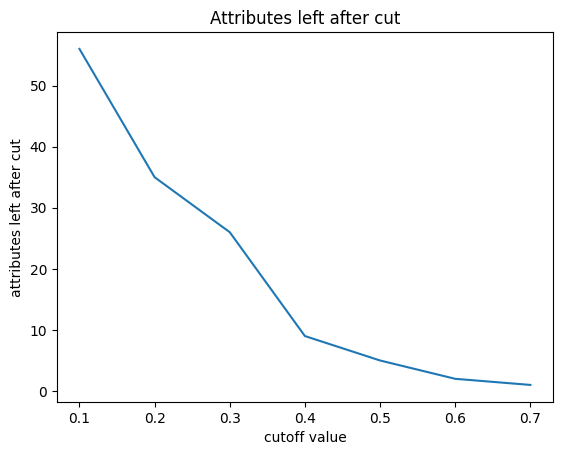

In [13]:
# checking correlation between attributes and target for diffe
data_corr = tr_data.corr()
num_attrs_after_cut = []
cuts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for cutoff_value in cuts:
    data_corr_cut = data_corr.abs() < cutoff_value
    indices_list = data_corr_cut.columns[data_corr_cut["target_sales"]]
    num_attrs_after_cut.append(tr_data.shape[1]-len(indices_list))

plt.plot(cuts, num_attrs_after_cut)
plt.title("Attributes left after cut")
plt.xlabel("cutoff value")
plt.ylabel("attributes left after cut")


In my opinion the best value is 0.25 as we cut the worst correlated column, yet we enough for the model to learn.

In [14]:
tr_data.corr().abs()['target_sales'].sort_values(ascending=False)[:35]

target_sales                                1.000000
salesRelativeToGlobalProductAverage_lag1    0.690648
sales_in_all_mcats                          0.557657
posTotalSalesLastPeriod_lag1                0.557657
sales_in_mcat_Dania_lunch                   0.556181
salesRelativeToGlobalPoSAverage_lag1        0.497495
sales_in_mcat_Makarony                      0.464848
qty_lag7                                    0.442484
qty_lag1                                    0.423240
sales_since_prev_delivery                   0.398690
available_products                          0.389985
qty_lag8                                    0.381696
qty_lag2                                    0.380290
qty_lag6                                    0.378066
qty_lag14                                   0.374685
sales_in_mcat_Zupy                          0.362273
qty_lag5                                    0.348906
qty_lag4                                    0.347944
qty_lag3                                    0.

The interesting fact is that the most correlated attributes are those related to the number of sales in the last period: if the sales were high last period, then they have to be high in this period.

OFC correlation is not the best metric to limit number of attributes, as high correlation does not need to mean high dependency between target and attribute (http://www.tylervigen.com/spurious-correlations).
In our case, it is probable that the correlation is accurate, as most people don't care about protein or salt in their chocolate bar, but about advertisment.

Lets check if different test return same answers

### ANOVA F-value test

In [15]:
f_scores, p_values = f_classif(tr_data.iloc[:, 1:], tr_data["target_sales"])

f_classif_results = pd.DataFrame({"f_scores": f_scores, "p_values": p_values}, index=tr_data.columns[1:]).sort_values(ascending=False, by="f_scores")
f_classif_results[:35]

,f_scores,p_values
salesRelativeToGlobalProductAverage_lag1,3137.483437,0.0
sales_in_mcat_Dania_lunch,1513.756610,0.0
posTotalSalesLastPeriod_lag1,1477.530075,0.0
sales_in_all_mcats,1477.530075,0.0
salesRelativeToGlobalPoSAverage_lag1,1060.956730,0.0
sales_in_mcat_Makarony,900.077941,0.0
qty_lag7,774.320970,0.0
qty_lag1,731.698609,0.0
available_products,689.249399,0.0
sales_since_prev_delivery,664.251000,0.0


Columns with highest scores are similar for both tests, ANOVA and correlation. We can conclude that the correlation test is right.

In [16]:
tr_data = corr_above_cutoff(tr_data, cutoff=0.2)
te_data = corr_above_cutoff(te_data, cutoff=0.2)
print(f"data shape: {tr_data.shape}")

data shape: (185097, 35)


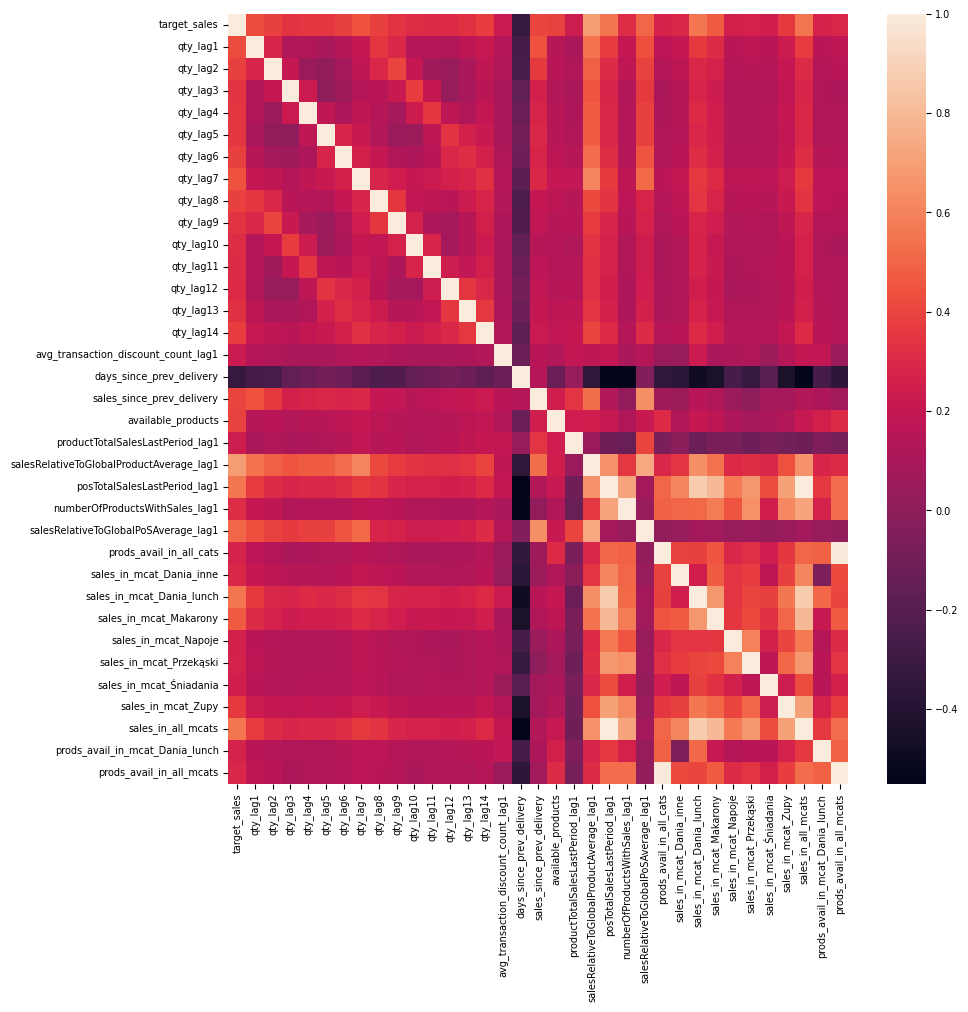

In [17]:
font = {'size'   : 7}
plt.rc('font', **font)

plt.figure(figsize=(10,10))
hm = sns.heatmap(tr_data.corr(), cbar=True, fmt="d")

## Split data into training,  validation and test sets

I don't have acces to target values in test data, as the data was acquired from KnowledgePit contest. I will conduct model evaluation only on training dataset, artificially spltting it into training, validation and test datasets.

In [18]:
tr_data, val_data, te_data = split(tr_data, train_size=0.6, validation_size=0.2, test_size=0.2)

print(f"Rows in training set:   {tr_data.shape[0]}")
print(f"Rows in validation set: {val_data.shape[0]}")
print(f"Rows in test set:       {te_data.shape[0]}")

Rows in training set:   111058
Rows in validation set: 37018
Rows in test set:       37018


## Save split datasets

In [19]:
tr_data.to_csv('data/project2_transformed_training_data.csv')
val_data.to_csv('data/project2_transformed_validation_data.csv')
te_data.to_csv('data/project2_transformed_test_data.csv')